In [ ]:
!pip install jcopml

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 100 kB 4.0 MB/s 
  Created wheel for jcopml: filename=jcopml-1.1.15-py2.py3-none-any.whl size=32026 sha256=2577484f749093d9135a0690be92c13cd4e49398f9eb89b40028618bef74805a
  Stored in directory: /root/.cache/pip/wheels/43/7a/bb/396851d7ac5c4c9342ec8657593da1eee1bad1854e54d51d81
Successfully built jcopml


### Import Dataset

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
import missingno as msno
warnings.simplefilter(action="ignore", category=FutureWarning)

In [ ]:
df = pd.read_csv('house_price.csv', index_col='ID')
df

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
ID,,,,,,,,,,,,,,
1,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
2,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
4,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
5,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2
7,0.08829,12.5,7.87,0,0.524,6.012,66.6,5.5605,5,311,15.2,395.60,12.43,22.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
500,0.17783,0.0,9.69,0,0.585,5.569,73.5,2.3999,6,391,19.2,395.77,15.10,17.5
502,0.06263,0.0,11.93,0,0.573,6.593,69.1,2.4786,1,273,21.0,391.99,9.67,22.4
503,0.04527,0.0,11.93,0,0.573,6.120,76.7,2.2875,1,273,21.0,396.90,9.08,20.6


### Cek data yang kosong

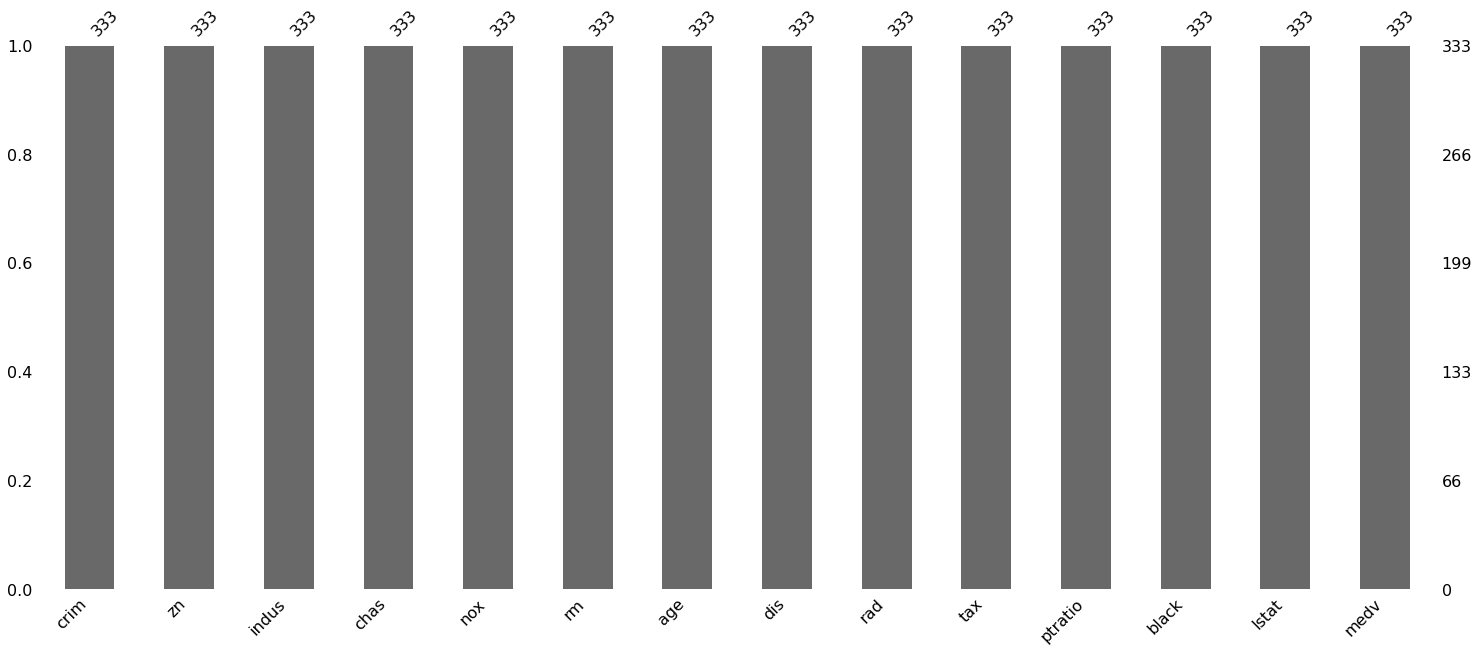

In [ ]:
msno.bar(df)

### Split Data

In [ ]:
from sklearn.model_selection import train_test_split

X = df.drop(columns='medv')
y = df.medv

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((266, 13), (67, 13), (266,), (67,))

In [ ]:
X_train.columns

Index(['crim', 'zn', 'indus', 'chas', 'nox', 'rm', 'age', 'dis', 'rad', 'tax',
       'ptratio', 'black', 'lstat'],
      dtype='object')

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, RobustScaler, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from jcopml.tuning import grid_search_params as gsp
from sklearn.model_selection import RandomizedSearchCV
from jcopml.tuning import random_search_params as rsp
from jcopml.plot import plot_correlation_matrix,plot_classification_report,plot_confusion_matrix,plot_residual,plot_association_matrix
from jcopml.feature_importance import mean_score_decrease
from xgboost import XGBRegressor
from sklearn.svm import SVR

### GridSearch Random Forest Regressor

In [ ]:
numerical_pipeline = Pipeline([
                               ('imputer', SimpleImputer(strategy='mean')),
                               ('scaler', MinMaxScaler())
])

categorical_pipeline = Pipeline([
                                 ('imputer', SimpleImputer(strategy='most_frequent')),
                                 ('scaler', OneHotEncoder())
])


preprocessor = ColumnTransformer([
                                  ('numeric', numerical_pipeline, ['crim', 'zn', 'indus', 'nox', 'rm', 'age', 'dis', 'rad', 'tax',
                                                           'ptratio', 'black', 'lstat']),
                                  ('categoric', categorical_pipeline, ['chas']),
])

pipeline = Pipeline([
                     ('prep', preprocessor),
                     ('algo', RandomForestRegressor(n_jobs=-1, random_state=42))
])

model = GridSearchCV(pipeline, gsp.rf_params, cv=3, n_jobs=-1, verbose=1)
model.fit(X_train, y_train)

print(model.best_params_)
print(model.score(X_train, y_train), model.score(X_test, y_test))

Fitting 3 folds for each of 81 candidates, totalling 243 fits
{'algo__max_depth': 20, 'algo__max_features': 0.6, 'algo__min_samples_leaf': 1, 'algo__n_estimators': 200}
0.9789763198446911 0.9127390151263305


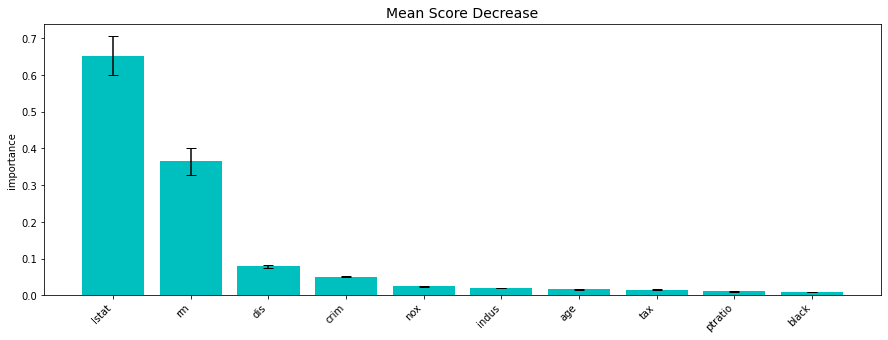

In [ ]:
df_imp = mean_score_decrease(X_train, y_train, model, plot=True, topk=10)

### RandomSearch Random Forest Regressor

In [ ]:
numerical_pipeline = Pipeline([
                               ('imputer', SimpleImputer(strategy='mean')),
                               ('scaler', MinMaxScaler())
])

categorical_pipeline = Pipeline([
                                 ('imputer', SimpleImputer(strategy='most_frequent')),
                                 ('scaler', OneHotEncoder())
])


preprocessor = ColumnTransformer([
                                  ('numeric', numerical_pipeline, ['crim', 'zn', 'indus', 'nox', 'rm', 'age', 'dis', 'rad', 'tax',
                                                           'ptratio', 'black', 'lstat']),
                                  ('categoric', categorical_pipeline, ['chas']),
])

pipeline = Pipeline([
                     ('prep', preprocessor),
                     ('algo', RandomForestRegressor(n_jobs=-1, random_state=42))
])

model_random = RandomizedSearchCV(pipeline, rsp.rf_params, cv=3, n_jobs=-1, verbose=1)
model_random.fit(X_train, y_train)

print(model_random.best_params_)
print(model_random.score(X_train, y_train), model_random.score(X_test, y_test))

Fitting 3 folds for each of 10 candidates, totalling 30 fits
{'algo__max_depth': 73, 'algo__max_features': 0.40373455768881805, 'algo__min_samples_leaf': 1, 'algo__n_estimators': 182}
0.9779212553709968 0.8834564925211099


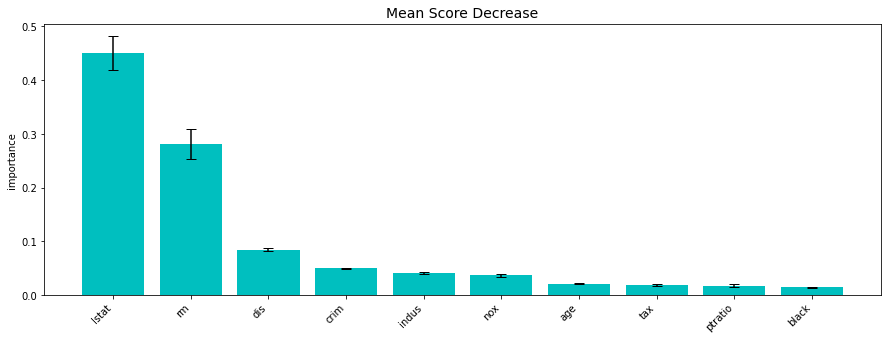

In [ ]:
df_imp = mean_score_decrease(X_train, y_train, model_random, plot=True, topk=10)

### RandomSearch XGBoost Regressor

In [ ]:
numerical_pipeline = Pipeline([
                               ('imputer', SimpleImputer(strategy='mean')),
                               ('scaler', MinMaxScaler())
])

categorical_pipeline = Pipeline([
                                 ('imputer', SimpleImputer(strategy='most_frequent')),
                                 ('scaler', OneHotEncoder())
])


preprocessor = ColumnTransformer([
                                  ('numeric', numerical_pipeline, ['crim', 'zn', 'indus', 'nox', 'rm', 'age', 'dis', 'rad', 'tax',
                                                           'ptratio', 'black', 'lstat']),
                                  ('categoric', categorical_pipeline, ['chas']),
])

pipeline = Pipeline([
                     ('prep', preprocessor),
                     ('algo', XGBRegressor(n_jobs=-1, random_state=42))
])

model_rsp_Grid = RandomizedSearchCV(pipeline, rsp.xgb_params, cv=5,n_iter= 100, n_jobs=-1, verbose=1)
model_rsp_Grid.fit(X_train, y_train)

print(model_rsp_Grid.best_params_)
print(model_rsp_Grid.score(X_train, y_train), model_rsp_Grid.score(X_test, y_test))

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[16:38:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
{'algo__colsample_bytree': 0.8985612360434737, 'algo__gamma': 7, 'algo__learning_rate': 0.043609519722506845, 'algo__max_depth': 4, 'algo__n_estimators': 111, 'algo__reg_alpha': 0.14444716461374346, 'algo__reg_lambda': 0.004287256184616561, 'algo__subsample': 0.5620675541783662}
0.9773816354195799 0.9268234814982027


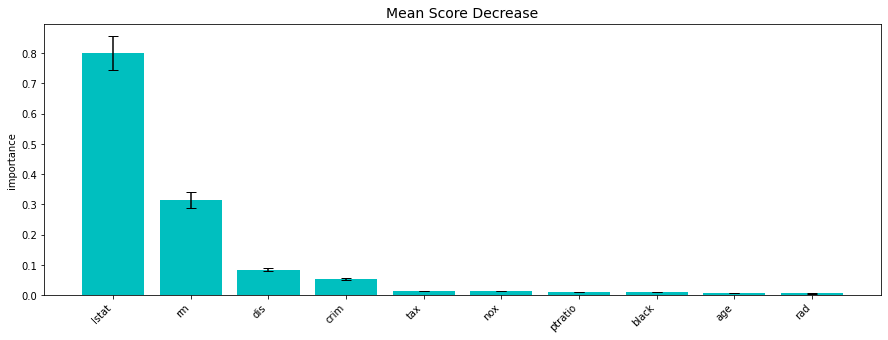

In [ ]:
df_imp = mean_score_decrease(X_train, y_train, model_rsp_Grid, plot=True, topk=10)

### GridSearch SVR

In [ ]:
numerical_pipeline = Pipeline([
                               ('imputer', SimpleImputer(strategy='mean')),
                               ('scaler', RobustScaler())
])

categorical_pipeline = Pipeline([
                                 ('imputer', SimpleImputer(strategy='most_frequent')),
                                 ('scaler', OneHotEncoder())
])


preprocessor = ColumnTransformer([
                                  ('numeric', numerical_pipeline, ['crim', 'zn', 'indus', 'nox', 'rm', 'age', 'dis', 'rad', 'tax',
                                                           'ptratio', 'black', 'lstat']),
                                  ('categoric', categorical_pipeline, ['chas']),
])

pipeline = Pipeline([
                     ('prep', preprocessor),
                     ('algo', SVR(max_iter=500))
])

model_SVR = GridSearchCV(pipeline, gsp.svm_params, cv=3, n_jobs=-1, verbose=1)
model_SVR.fit(X_train, y_train)

print(model_SVR.best_params_)
print(model_SVR.score(X_train, y_train), model_SVR.score(X_test, y_test))

Fitting 3 folds for each of 49 candidates, totalling 147 fits
{'algo__C': 100.0, 'algo__gamma': 0.01}
0.8181224393006585 0.8341091034148285


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


In [ ]:
X_train.iloc[:1]

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat
ID,,,,,,,,,,,,,
340,0.05497,0.0,5.19,0,0.515,5.985,45.4,4.8122,5,224,20.2,396.9,9.74


### Prediksi Model

In [ ]:
X_pred = pd.DataFrame([[0.01, 50, 3, 1, 0.8, 3, 20, 4, 1, 300, 10, 400, 5]], columns=X_train.columns)
X_pred

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat
0,0.01,50,3,1,0.8,3,20,4,1,300,10,400,5


In [ ]:
model.predict(X_pred)

array([25.701])

In [ ]:
model_random.predict(X_pred)

array([27.09340659])

In [ ]:
model_rsp_Grid.predict(X_pred)

array([25.550064], dtype=float32)

In [ ]:
model_SVR.predict(X_pred)

array([15.47341862])